# Predicting behaviour of C. elegans from network principles 

<img src="assets/yan2018_worm.jpg" alt="disease network" style="float:right" width="750" />


Regarding the brain as a network is another great starting point to apply graph theory. This idea of modelling the brain using network science is far from new, but having the computational tools to do anything interesting about it is. This notebook deals with one of such application on the much studied nematode C. *elegans*. The adult worm has only 959 cells. It has 302 neurons, 282 of which are play a role in controlling the body movement (the remaining 20 control the pharynx). A number of studies have mapped this connection diagram (*connectome*), and a complete (although error-prone) map exists freely available online.

In [a Nature study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5710776/) the topology of the C. *elegans* connectome was analysed using control theory to discover a neuron. The finding was later experimentally validated by laser ablation. This is a brilliant example of how we can apply graph theory to a connectome to predict phenomena in biology. Here we will attempt to reproduce parts of that study.

Relevant literature:
- https://www.barabasilab.com/publications/caenorhabditis-elegans-and-the-network-control-framework-faqs
- https://www.barabasilab.com/publications/synthetic-ablations-in-the-c-elegans-nervous-system
- http://barabasi.com/f/919.pdf
- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001066
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1995545/
- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001066
- https://www.kaggle.com/rubmanoid/c-elegans-connectome #data

Validation data from the experiment (video): https://figshare.com/s/72716a92be1ab0f1e1d4

Useful information: https://www.wormatlas.org/neuronalwiring.html#Neuronconnections

### Structure of the notebook
The first part of this notebook deals with basic exploration, cleaning and processing of the data and constructing the graph. We reproduce a figure from the paper (more or less) before we deep dive into the science of control theory with simple examples. Finally we apply the algorithms to the connectome of C. elegans and do virtual ablation studies to determine crucial nodes.

As usual, we start by importing necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Next we locate and import the connectome data, downloaded from wormatlas.org.

In [315]:
data_dir = Path.cwd() / 'data'
print(data_dir.exists())

data_fn = data_dir / 'NeuronConnect_wormatlas.xls'
print(data_fn.exists())

True
True


In [316]:
data = pd.read_excel(data_fn)

In [317]:
data.head()

,Neuron 1,Neuron 2,Type,Nbr
0,ADAR,ADAL,EJ,1
1,ADFL,ADAL,EJ,1
2,ASHL,ADAL,EJ,1
3,AVDR,ADAL,EJ,2
4,PVQL,ADAL,EJ,1


In [318]:
data.loc[:, 'Type'].unique()

array(['EJ', 'Sp', 'R', 'Rp', 'S', 'NMJ'], dtype=object)

The data has four fields. **Neuron 1** is the pre-synaptic neuron and **Neuron 2** is the post-synaptic. **Type** is the type of synapse, and **Nbr** is the number of synapses from Neuron1 to Neuron2. We are not interested in the Type column.

In [319]:
#electric junctions
# data[data.loc[:,'Type'] == 'EJ']

In [320]:
(data.loc[:,'Neuron 2'] == 'NMJ').unique()

array([False,  True])

In [321]:
data[data.Type=='NMJ'].loc[:,'Neuron 1'].unique()

array(['AS02', 'AS03', 'AS04', 'AS05', 'AS06', 'AS09', 'AS11', 'AVFL',
       'AVFR', 'AVKR', 'AVL', 'DA01', 'DA02', 'DA03', 'DA04', 'DA05',
       'DA06', 'VC01', 'VC03', 'AS01', 'DA09', 'DB01', 'DB02', 'DB03',
       'DB04', 'DD01', 'DD02', 'DD03', 'DD05', 'DD06', 'DVB', 'HSNL',
       'HSNR', 'IL1DL', 'IL1DR', 'IL1L', 'IL1R', 'IL1VL', 'IL1VR', 'PDA',
       'PDB', 'PLNL', 'PVNL', 'PVNR', 'RID', 'RIML', 'RIMR', 'RIVL',
       'RIVR', 'RMDDL', 'RMDDR', 'RMDL', 'RMDR', 'RMDVL', 'RMDVR', 'RMED',
       'RMEL', 'RMER', 'RMEV', 'RMFL', 'RMGL', 'RMGR', 'RMHL', 'RMHR',
       'SMBDL', 'SMBDR', 'SMBVL', 'SMBVR', 'SMDDL', 'SMDDR', 'SMDVL',
       'SMDVR', 'URADL', 'URADR', 'URAVL', 'URAVR', 'VA01', 'VA02',
       'VA03', 'VA04', 'VA05', 'VA06', 'VA07', 'VA08', 'VA09', 'VA11',
       'VA12', 'VB01', 'VB02', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07',
       'VB08', 'VB09', 'VB10', 'VB11', 'VC02', 'VC04', 'VC05', 'VC06',
       'VD01', 'VD02', 'VD03', 'VD04', 'VD05', 'VD06', 'VD07', 'VD08',
       

#### Exercise. How many neurons are there?

In [322]:
data.loc[:,'Neuron 1'].unique().shape
# should be 280

(281,)

In [323]:
data[data.Type=='NMJ']

,Neuron 1,Neuron 2,Type,Nbr
6264,AS02,NMJ,NMJ,11
6265,AS03,NMJ,NMJ,12
6266,AS04,NMJ,NMJ,9
6267,AS05,NMJ,NMJ,10
6268,AS06,NMJ,NMJ,10
...,...,...,...,...
6412,VD09,NMJ,NMJ,28
6413,VD10,NMJ,NMJ,22
6414,VD11,NMJ,NMJ,11
6415,VD12,NMJ,NMJ,13


#### Exercise. Some are termed "NMJ" (neuromuscular junction). This is not a specific cell but refers to any muscle cell. Remove these from the data.

In [324]:
# remove neuromuscular junction (will add later from other dataset)
data = data[data.loc[:,'Neuron 2'] != 'NMJ']

In [325]:
data.loc[:,'Neuron 1'].unique().shape

(280,)

In [326]:
data.loc[:,'Neuron 2'].unique()

array(['ADAL', 'ADAR', 'ADEL', 'ADER', 'ADFL', 'ADFR', 'ADLL', 'ADLR',
       'AFDL', 'AFDR', 'AIAL', 'AIAR', 'AIBL', 'AIBR', 'AIML', 'AIMR',
       'AINL', 'AINR', 'AIYL', 'AIYR', 'AIZL', 'AIZR', 'ALA', 'ALML',
       'ALMR', 'ALNL', 'ALNR', 'AQR', 'AS01', 'AS02', 'AS03', 'AS04',
       'AS05', 'AS06', 'AS07', 'AS08', 'AS09', 'AS10', 'AS11', 'ASEL',
       'ASER', 'ASGL', 'ASGR', 'ASHL', 'ASHR', 'ASIL', 'ASIR', 'ASJL',
       'ASJR', 'ASKL', 'ASKR', 'AUAL', 'AUAR', 'AVAL', 'AVAR', 'AVBL',
       'AVBR', 'AVDL', 'AVDR', 'AVEL', 'AVER', 'AVFL', 'AVFR', 'avfr',
       'AVG', 'AVHL', 'AVHR', 'AVJL', 'AVJR', 'AVKL', 'AVKR', 'AVL',
       'AVM', 'AWAL', 'AWAR', 'AWBL', 'AWBR', 'AWCL', 'AWCR', 'BAGL',
       'BAGR', 'BDUL', 'BDUR', 'CEPDL', 'CEPDR', 'CEPVL', 'CEPVR', 'DA01',
       'DA02', 'DA03', 'DA04', 'DA05', 'DA06', 'DA07', 'DA08', 'DA09',
       'DB01', 'DB02', 'DB03', 'DB04', 'DB05', 'DB06', 'DB07', 'DD01',
       'DD02', 'DD03', 'DD04', 'DD05', 'DD06', 'DVA', 'DVB', 'DVC',
       'FL

Next we do not care about the type of connection, and will remove the column.

In [327]:
print(data.Type.unique())


['EJ' 'Sp' 'R' 'Rp' 'S']


#### Ex 1: a) remove the *Type* and Number column. 

In [328]:
data.drop(['Type','Nbr'], axis=1, inplace=True)
#comment: the "inplace=True" ensures that the data is dropped in place, without needing to write something 
#along the lines of data = data.drop(...) 

In [329]:
data.head()

,Neuron 1,Neuron 2
0,ADAR,ADAL
1,ADFL,ADAL
2,ASHL,ADAL
3,AVDR,ADAL
4,PVQL,ADAL


In [330]:
#Rename to source and target 
data.columns = ['source', 'target']

#### The current data only holds information about the neurons. We also need to know the connections to the muscles, as these are the cells that control motion.

In [331]:
muscles_fn = data_dir / 'Neuron_to_muscles_wormatlas.xls'
print(muscles_fn.exists())

True


#### Ex. Read the excel file into a pandas dataframe called 'muscles'

In [332]:
muscles = pd.read_excel(muscles_fn)

In [333]:
muscles.shape

(650, 4)

In [334]:
muscles.Landmark.unique()

array(['Sensory', 'SensoryNB', 'MDL05', 'MDR05', 'MDL08', 'MDR08',
       'MDL07', 'MDR07', 'MDL10', 'MDR10', 'MDL09', 'MDR09', 'MDL12',
       'MDR12', 'MDL11', 'MDR11', 'MDL14', 'MDR14', 'MDL13', 'MDR13',
       'MDL16', 'MDR16', 'MDL15', 'MDR15', 'MDL18', 'MDR18', 'MDL20',
       'MDR20', 'MDL17', 'MDR17', 'MDL19', 'MDR19', 'MDL22', 'MDR22',
       'MDL21', 'MDR21', 'MVL12', 'MVL11', 'MVL14', 'MVR14', 'MVL10',
       'MVR10', 'MVL03', 'MVR04', 'MANAL', 'MVULVA', 'MDL02', 'MDL01',
       'MDL04', 'MDR02', 'MDR01', 'MDL03', 'MVL01', 'MDR03', 'MVR01',
       'MVR03', 'MVL02', 'MVR02', 'MVL22', 'MVR21', 'MVL09', 'MVL13',
       'MVR05', 'MVL05', 'MVL07', 'MVR06', 'MVR08', 'MVL06', 'MVL08',
       'MDR04', 'MVR07', 'MVL04', 'MDL06', 'MDR06', 'MVR09', 'MVR12',
       'MVR11', 'MVR13', 'MVL16', 'MVR16', 'MVL15', 'MVR15', 'MVL18',
       'MVR18', 'MVL17', 'MVR17', 'MVL19', 'MVR19', 'MVL20', 'MVR20',
       'MVL21', 'MVR22', 'MVL23', 'MVR23', 'MVR24', 'MDL24', 'MDL23',
       'MDR24', 'MDR23

In [335]:
muscles.head()

,Neuron,Landmark,Landmark Position,Weight
0,IL1R,Sensory,0.0,1.0
1,IL2L,Sensory,0.0,1.0
2,IL2R,Sensory,0.0,1.0
3,IL1L,Sensory,0.0,1.0
4,IL2VL,Sensory,0.0,1.0


In [336]:
muscles.describe()

,Landmark Position,Weight
count,650.000000,650.000000
mean,0.346277,3.001695
std,0.278176,1.976951
min,0.000000,0.428571
25%,0.100000,1.000000
50%,0.290000,2.708333
75%,0.550000,4.675676
max,1.000000,13.000000


We don't care about the column "Landmark Position" or weight.

In [337]:
muscles.drop(columns=['Landmark Position', 'Weight'], inplace=True)
muscles.head()

,Neuron,Landmark
0,IL1R,Sensory
1,IL2L,Sensory
2,IL2R,Sensory
3,IL1L,Sensory
4,IL2VL,Sensory


As seen above, the data contains information about other connections too, like input from sensory cells, and muscle cells of no interest. We wish to only keep body wall muscles (those involved in controlling locomotion).

In [338]:
## only keep body wall muscles - the ones with name prefixes MDR/L or MVR/L.
# pandas supports regex:
bdwl = muscles.loc[:,"Landmark"].str.match(pat = "^M[DV][LR]") 

#comment: this matching algorithm is known as a regular expression. This one lets you match for a string
#beginning with and M, followed by a D or V, followed by a L or R. In other words it will match anything 
#starting with "MDL", "MDR", "MVL" or "MVR"

In [339]:
# number of body wall muscles
print('Body wall muscles:')
print(muscles[bdwl].loc[:,"Landmark"].unique())
muscles[bdwl].loc[:,"Landmark"].unique().shape

# should be 95

Body wall muscles:
['MDL05' 'MDR05' 'MDL08' 'MDR08' 'MDL07' 'MDR07' 'MDL10' 'MDR10' 'MDL09'
 'MDR09' 'MDL12' 'MDR12' 'MDL11' 'MDR11' 'MDL14' 'MDR14' 'MDL13' 'MDR13'
 'MDL16' 'MDR16' 'MDL15' 'MDR15' 'MDL18' 'MDR18' 'MDL20' 'MDR20' 'MDL17'
 'MDR17' 'MDL19' 'MDR19' 'MDL22' 'MDR22' 'MDL21' 'MDR21' 'MVL12' 'MVL11'
 'MVL14' 'MVR14' 'MVL10' 'MVR10' 'MVL03' 'MVR04' 'MDL02' 'MDL01' 'MDL04'
 'MDR02' 'MDR01' 'MDL03' 'MVL01' 'MDR03' 'MVR01' 'MVR03' 'MVL02' 'MVR02'
 'MVL22' 'MVR21' 'MVL09' 'MVL13' 'MVR05' 'MVL05' 'MVL07' 'MVR06' 'MVR08'
 'MVL06' 'MVL08' 'MDR04' 'MVR07' 'MVL04' 'MDL06' 'MDR06' 'MVR09' 'MVR12'
 'MVR11' 'MVR13' 'MVL16' 'MVR16' 'MVL15' 'MVR15' 'MVL18' 'MVR18' 'MVL17'
 'MVR17' 'MVL19' 'MVR19' 'MVL20' 'MVR20' 'MVL21' 'MVR22' 'MVL23' 'MVR23'
 'MVR24' 'MDL24' 'MDL23' 'MDR24' 'MDR23']


(95,)

#### Ex: Remove the rows in `muscles` which are not body wall muscles.

In [340]:
# %load solutions/...
muscles = muscles[bdwl]

In [341]:
muscles.head()

,Neuron,Landmark
86,ADEL,MDL05
87,AS01,MDL05
88,AS01,MDR05
89,AS01,MDL08
90,AS01,MDR08


We chain the two dataframes together.

In [342]:
muscles.rename(columns = dict(zip(muscles.columns, data.columns)), inplace=True)
data = data.append(muscles, ignore_index=True)
data.head()

,source,target
0,ADAR,ADAL
1,ADFL,ADAL
2,ASHL,ADAL
3,AVDR,ADAL
4,PVQL,ADAL


In [343]:
# rename
muscles

,source,target
86,ADEL,MDL05
87,AS01,MDL05
88,AS01,MDR05
89,AS01,MDL08
90,AS01,MDR08
...,...,...
645,DA09,MDR23
646,AS11,MDL24
647,AS11,MDL23
648,AS11,MDR24


In [344]:
data.tail()

,source,target
6811,DA09,MDR23
6812,AS11,MDL24
6813,AS11,MDL23
6814,AS11,MDR24
6815,AS11,MDR23


In [345]:
muscles

,source,target
86,ADEL,MDL05
87,AS01,MDL05
88,AS01,MDR05
89,AS01,MDL08
90,AS01,MDR08
...,...,...
645,DA09,MDR23
646,AS11,MDL24
647,AS11,MDL23
648,AS11,MDR24


In [346]:
# cell / neuron categories
motor_neurons = muscles[bdwl].loc[:,'source'].unique()
muscle_cells = muscles[bdwl].loc[:,'target'].unique()

Then drop the weight column, as we are only interested in the *structural* (unweighted) diagram.

In [347]:
# discard the synapse weights
#data.drop(columns=['Weight'], inplace=True)

Currently, we have both neurons and muscle cells in the dataframe, so we rename it more accurately:

In [348]:
data.head()

,source,target
0,ADAR,ADAL
1,ADFL,ADAL
2,ASHL,ADAL
3,AVDR,ADAL
4,PVQL,ADAL


In [349]:
data.shape

(6816, 2)

# Create the graph
Networkx can read this format as into a Graph object using `from_pandas_edgelist`:

In [350]:
G = nx.from_pandas_edgelist(data, create_using=nx.DiGraph)

In [351]:
print(G.number_of_nodes())

376


Currently, the network is disconnected (some subnetworks are unreachable from eachother), probably because of incomplete data. We can proceed by only keeping the largest one.

In [352]:
[cc for cc in nx.connected_components(nx.Graph(G))] # have to convert to undirected graph first

[{'ADAL',
  'ADAR',
  'ADEL',
  'ADER',
  'ADFL',
  'ADFR',
  'ADLL',
  'ADLR',
  'AFDL',
  'AFDR',
  'AIAL',
  'AIAR',
  'AIBL',
  'AIBR',
  'AIML',
  'AIMR',
  'AINL',
  'AINR',
  'AIYL',
  'AIYR',
  'AIZL',
  'AIZR',
  'ALA',
  'ALML',
  'ALMR',
  'ALNL',
  'ALNR',
  'AQR',
  'AS01',
  'AS02',
  'AS03',
  'AS04',
  'AS05',
  'AS06',
  'AS07',
  'AS08',
  'AS09',
  'AS10',
  'AS11',
  'ASEL',
  'ASER',
  'ASGL',
  'ASGR',
  'ASHL',
  'ASHR',
  'ASIL',
  'ASIR',
  'ASJL',
  'ASJR',
  'ASKL',
  'ASKR',
  'AUAL',
  'AUAR',
  'AVAL',
  'AVAR',
  'AVBL',
  'AVBR',
  'AVDL',
  'AVDR',
  'AVEL',
  'AVER',
  'AVFL',
  'AVFR',
  'AVG',
  'AVHL',
  'AVHR',
  'AVJL',
  'AVJR',
  'AVKL',
  'AVKR',
  'AVL',
  'AVM',
  'AWAL',
  'AWAR',
  'AWBL',
  'AWBR',
  'AWCL',
  'AWCR',
  'BAGL',
  'BAGR',
  'BDUL',
  'BDUR',
  'CEPDL',
  'CEPDR',
  'CEPVL',
  'CEPVR',
  'DA01',
  'DA02',
  'DA03',
  'DA04',
  'DA05',
  'DA06',
  'DA07',
  'DA08',
  'DA09',
  'DB01',
  'DB02',
  'DB03',
  'DB04',
  'DB05',
 

Scroll all the way down and see a component disconnected to the rest of the graph, consisting of the 2 nodes `avfl` and `avfr`. This is a matter of incomplete data, but for the sake of the math, we should delete these two nodes from the graph:

In [354]:
print(G.number_of_nodes())
G.remove_nodes_from(['avfl', 'avfr'], )
print(G.number_of_nodes())

376
374


## Identifying hubs
The nodes sorted by degree indicate the more influential nodes (high degree) versus less influential.

In [353]:
deg = sorted(G.degree(), key = lambda x: x[1], reverse=True)
print('Top degrees:')
deg[:10]

Top degrees:


[('AVAR', 186),
 ('AVAL', 184),
 ('AVBL', 150),
 ('AVBR', 148),
 ('AVER', 112),
 ('AVDR', 110),
 ('AVEL', 110),
 ('PVCL', 108),
 ('PVCR', 106),
 ('DVA', 100)]

#### Ex 2. Make a list of the node degrees in G. Convert it to a numpy array. (Do not sort it)

In [75]:
node_degrees = np.array([e for v,e in list(G.degree())])

In [76]:
node_degrees

array([ 44,  50,  20,  40, 110,  28,  59,  42,  68,  78, 186, 150, 148,
        88, 110,  58,  18,  32,  46,  60,  50,  48,  60,  34,  58,  36,
        36,  44,  48,  48,  34, 184,  62,  66,  32,  37,  49,  42,  28,
        18,  49,  16,  56,  22,  40,  30,  29,  28,  36,  66,  30,  66,
        50,  64,  27,  55,  21,   8,  14,  40,  24,  68,  16, 112,  38,
        26,  48,  26,  42,  49,  20,  48,  26,  26,  30,  44,  27,  28,
        48,  30,  28,  48,  30,  30,  50,  72,  28,  34,  34,  42,  32,
        44,  33,  26,  24, 108,  16,  12,  26,  30,  20,  34,  14,  16,
        24,  24,  48,  26,  18,  20,  38,  54,  56,  26,  66,  70,  26,
        32,  24,  51,  36,  56,  78,  22,  45,  44,  28,  46,  40,  12,
        30,  54,  24,  38, 100,  33,  38, 106,  45,  14,  39,  48,  10,
        10,  24,  42,  26,  28,  34,  38,  30,  40,  40,  24,  28,  50,
        28,  22,  34,  34,  22,  28,  46,  34,  22,  46,  36,  22,  30,
        32,  28,  36,  12,   8,  12,  20,  16,   8,  22,  13,  4

In [361]:
from matplotlib import cm

In [362]:
#experiment with layouts

#pos = nx.kamada_kawai_layout(G)
#pos = nx.layout.spectral_layout(G)
#
#nx.draw_networkx_nodes(G, pos, node_size=node_degrees*13)

In [363]:
#nx.draw_networkx_nodes(G, pos=nx.kamada_kawai_layout(G), node_color=colors.values())#,
#                       #node_size=node_degrees*10)

### Give nodal properties from the node category (sensory, muscle...)

In [77]:
landmark = pd.read_excel('data/NeuronFixedPoints.xls')
#muscles = pd.read_excel(muscles_fn)
landmark.head()
landmark.Landmark.unique()

array(['Sensory', 'SensoryNB', 'MDL05', 'MDR05', 'MDL08', 'MDR08',
       'MDL07', 'MDR07', 'MDL10', 'MDR10', 'MDL09', 'MDR09', 'MDL12',
       'MDR12', 'MDL11', 'MDR11', 'MDL14', 'MDR14', 'MDL13', 'MDR13',
       'MDL16', 'MDR16', 'MDL15', 'MDR15', 'MDL18', 'MDR18', 'MDL20',
       'MDR20', 'MDL17', 'MDR17', 'MDL19', 'MDR19', 'MDL22', 'MDR22',
       'MDL21', 'MDR21', 'MVL12', 'MVL11', 'MVL14', 'MVR14', 'MVL10',
       'MVR10', 'MVL03', 'MVR04', 'MANAL', 'MVULVA', 'MDL02', 'MDL01',
       'MDL04', 'MDR02', 'MDR01', 'MDL03', 'MVL01', 'MDR03', 'MVR01',
       'MVR03', 'MVL02', 'MVR02', 'MVL22', 'MVR21', 'MVL09', 'MVL13',
       'MVR05', 'MVL05', 'MVL07', 'MVR06', 'MVR08', 'MVL06', 'MVL08',
       'MDR04', 'MVR07', 'MVL04', 'MDL06', 'MDR06', 'MVR09', 'MVR12',
       'MVR11', 'MVR13', 'MVL16', 'MVR16', 'MVL15', 'MVR15', 'MVL18',
       'MVR18', 'MVL17', 'MVR17', 'MVL19', 'MVR19', 'MVL20', 'MVR20',
       'MVL21', 'MVR22', 'MVL23', 'MVR23', 'MVR24', 'MDL24', 'MDL23',
       'MDR24', 'MDR23

These data has a different category each muscle cell (those that starts with 'M'). In other words, the neurons that innervate them are motor neurons. We will replace them with just 'Motor'.

In [355]:
lmks=landmark.iloc[:,[0,1]]
print(lmks.Landmark.unique())

# hacky
lmks.replace('^M', np.nan, regex=True, inplace=True)
lmks.fillna('Motor', inplace=True)
lmks.Landmark.unique()

['Sensory' 'SensoryNB' 'MDL05' 'MDR05' 'MDL08' 'MDR08' 'MDL07' 'MDR07'
 'MDL10' 'MDR10' 'MDL09' 'MDR09' 'MDL12' 'MDR12' 'MDL11' 'MDR11' 'MDL14'
 'MDR14' 'MDL13' 'MDR13' 'MDL16' 'MDR16' 'MDL15' 'MDR15' 'MDL18' 'MDR18'
 'MDL20' 'MDR20' 'MDL17' 'MDR17' 'MDL19' 'MDR19' 'MDL22' 'MDR22' 'MDL21'
 'MDR21' 'MVL12' 'MVL11' 'MVL14' 'MVR14' 'MVL10' 'MVR10' 'MVL03' 'MVR04'
 'MANAL' 'MVULVA' 'MDL02' 'MDL01' 'MDL04' 'MDR02' 'MDR01' 'MDL03' 'MVL01'
 'MDR03' 'MVR01' 'MVR03' 'MVL02' 'MVR02' 'MVL22' 'MVR21' 'MVL09' 'MVL13'
 'MVR05' 'MVL05' 'MVL07' 'MVR06' 'MVR08' 'MVL06' 'MVL08' 'MDR04' 'MVR07'
 'MVL04' 'MDL06' 'MDR06' 'MVR09' 'MVR12' 'MVR11' 'MVR13' 'MVL16' 'MVR16'
 'MVL15' 'MVR15' 'MVL18' 'MVR18' 'MVL17' 'MVR17' 'MVL19' 'MVR19' 'MVL20'
 'MVR20' 'MVL21' 'MVR22' 'MVL23' 'MVR23' 'MVR24' 'MDL24' 'MDL23' 'MDR24'
 'MDR23']


array(['Sensory', 'SensoryNB', 'Motor'], dtype=object)

In [356]:
lmks.head()

,Neuron,Landmark
0,IL1R,Sensory
1,IL2L,Sensory
2,IL2R,Sensory
3,IL1L,Sensory
4,IL2VL,Sensory


In [357]:
mapping = dict(lmks.values)

# set node attributes
dummy = {k:v for k,v in zip(G.nodes, np.repeat('Unknown', G.number_of_nodes()))}
nx.set_node_attributes(G, dummy, 'Type')
nx.set_node_attributes(G, mapping, 'Type')

# color the muscle cells themselves
mapping = {k:'Muscle' for k in G.nodes if k.startswith('M')}
nx.set_node_attributes(G, mapping, 'Type')

[G.nodes[node] for node in G.nodes]


colors = nx.get_node_attributes(G, 'Type') 
# set some colors
cattocol = {'Unknown':'orange', 
            'Sensory':'dodgerblue', 
            'SensoryNB':'green', 
            'Motor':'yellow', 
            'Muscle':'fuchsia'}

for k,v in colors.items():
    colors[k] = cattocol[v]

In [358]:
nx.get_node_attributes(G,'Type')

{'ADAR': 'Unknown',
 'ADAL': 'Unknown',
 'ADFL': 'Sensory',
 'ASHL': 'Sensory',
 'AVDR': 'Unknown',
 'PVQL': 'Unknown',
 'ADEL': 'Motor',
 'AIAL': 'Unknown',
 'AIBL': 'Unknown',
 'AIBR': 'Unknown',
 'AVAR': 'Unknown',
 'AVBL': 'Unknown',
 'AVBR': 'Unknown',
 'AVDL': 'Unknown',
 'AVEL': 'Unknown',
 'AVJR': 'Unknown',
 'AWAL': 'Sensory',
 'FLPR': 'Sensory',
 'PVPL': 'Unknown',
 'PVR': 'Sensory',
 'RICL': 'Unknown',
 'RICR': 'Unknown',
 'RIML': 'Motor',
 'RIPL': 'Unknown',
 'RMGL': 'Motor',
 'SMDVR': 'Motor',
 'ADFR': 'Sensory',
 'ASHR': 'Sensory',
 'PVQR': 'Unknown',
 'ADER': 'Sensory',
 'AIAR': 'Unknown',
 'AVAL': 'Unknown',
 'AVJL': 'Unknown',
 'RIMR': 'Motor',
 'RIPR': 'Unknown',
 'RIVR': 'Motor',
 'RMGR': 'Motor',
 'SMDVL': 'Motor',
 'URBR': 'Sensory',
 'AINL': 'Unknown',
 'AVKR': 'Motor',
 'ALA': 'Unknown',
 'AVL': 'Motor',
 'BDUL': 'Unknown',
 'CEPDL': 'Sensory',
 'FLPL': 'Sensory',
 'IL1L': 'Motor',
 'IL2L': 'Sensory',
 'OLLL': 'Sensory',
 'RIAL': 'Unknown',
 'RIFL': 'Unknown',
 '

#### Ex. Plot the network, set the node size to be proportional to the node degrees, and color to from color.values(). 
Hint: due to slow plotting it can be smart to experiment with some dummy data.

In [48]:
#nx.draw_networkx_nodes(G, pos=nx.circular_layout(G), nodelist=nodelist, 
#                       node_color='dodgerblue')

NameError: name 'nodelist' is not defined

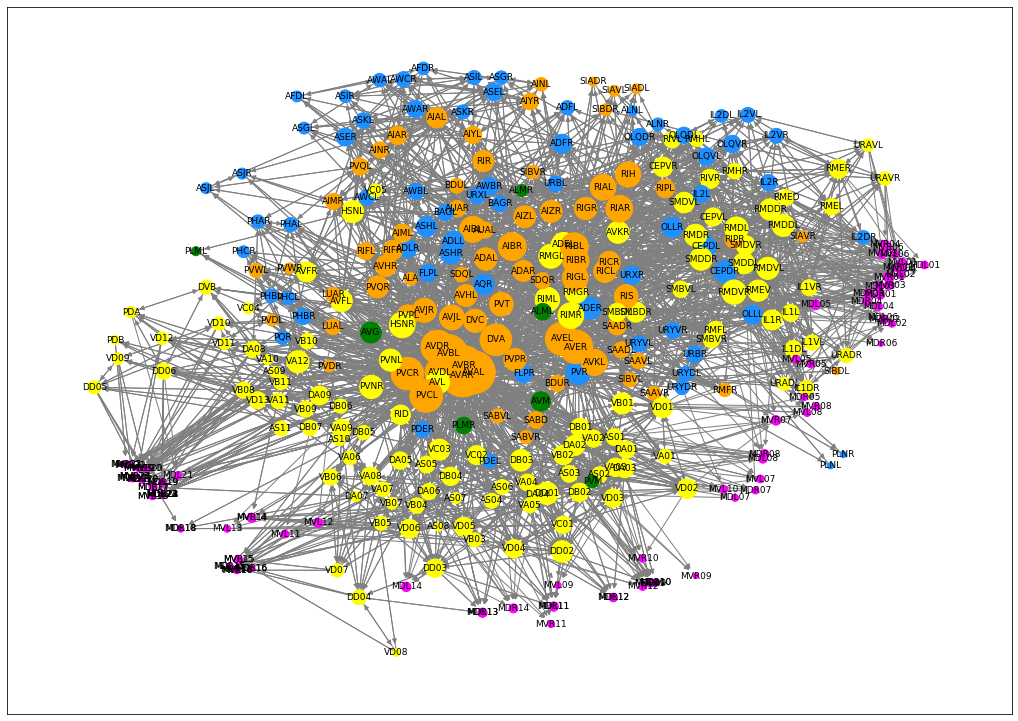

In [319]:
# %load solutions/...

figsize = (18,13)
plt.figure(figsize=figsize)

pos = nx.kamada_kawai_layout(G)


nx.draw_networkx_nodes(G, pos, node_color=colors.values(),
                       node_size=node_degrees*10)

nx.draw_networkx_edges(G, pos, edge_color='gray')

nx.draw_networkx_labels(G, pos, font_size=9)

plt.show()

In [84]:
G.nodes['AVM']

{'Type': 'SensoryNB'}

In [85]:
G.nodes['PDB']
list(G.neighbors('PDB'))

['AS11', 'RID', 'VD13', 'MVL22', 'MVR21']

In [86]:
nx.planarity.check_planarity(G)

(False, None)

In [87]:
deg[:11]

[('AVAR', 186),
 ('AVAL', 184),
 ('AVBL', 150),
 ('AVBR', 148),
 ('AVER', 112),
 ('AVDR', 110),
 ('AVEL', 110),
 ('PVCL', 108),
 ('PVCR', 106),
 ('DVA', 100),
 ('AVDL', 88)]

So already, simply by computing the node degree, our attention is directed to the most influential nodes. How do we know these are more important? Previous experiments have shown that the four top nodes, AVAR, AVAL, AVBR, AVBL, were already experimentally known to single-handedly cause motor dysfunction through laser ablation. This is not surprising, considering how many connections that are lost by removing one of them.

The neurons AVDR, PVCR, PVCL, AVDL which are ranked at 6th, 8th, 9th and 11th in the node degree hierarchy have also been expermentally validated as being crucial (by deactivating just a single one of these neurons, the worm would have locomotive defects). 

#### Conclusion
From this basic observation, we can safely say that network *hubs* are particularly important for network function.

We can also experiment with other topological metrics.

In [88]:
btw = nx.betweenness_centrality(G)
srtd = sorted(btw.items(), key = lambda item: item[1], reverse=True)
print('Top degrees:')
srtd[:10]

Top degrees:


[('AVAL', 0.08049126949798904),
 ('AVAR', 0.07931456046074402),
 ('AVBR', 0.05243117708481427),
 ('AVBL', 0.04885551229203308),
 ('DVA', 0.02960154274638137),
 ('AVER', 0.02935651591366546),
 ('AVEL', 0.026938812217419818),
 ('PVCR', 0.02183930250900443),
 ('RIBL', 0.021400072465526603),
 ('PVCL', 0.02125133753284057)]

In [89]:
srtd

[('AVAL', 0.08049126949798904),
 ('AVAR', 0.07931456046074402),
 ('AVBR', 0.05243117708481427),
 ('AVBL', 0.04885551229203308),
 ('DVA', 0.02960154274638137),
 ('AVER', 0.02935651591366546),
 ('AVEL', 0.026938812217419818),
 ('PVCR', 0.02183930250900443),
 ('RIBL', 0.021400072465526603),
 ('PVCL', 0.02125133753284057),
 ('PVR', 0.018043204356239653),
 ('AIBR', 0.016673400590212776),
 ('AVDR', 0.016621932041578368),
 ('RIBR', 0.013658493892253615),
 ('AIBL', 0.013160024628766361),
 ('RMGL', 0.012798289926909545),
 ('RIGL', 0.01155352371438624),
 ('HSNR', 0.011394267412538852),
 ('ADEL', 0.010734200142163728),
 ('PVT', 0.010615971670322922),
 ('RIAR', 0.01055620308061141),
 ('PVNR', 0.009911290718089447),
 ('RMEV', 0.00949073596430963),
 ('RIMR', 0.00944354140781164),
 ('AVL', 0.00926401555449323),
 ('VA09', 0.008953109393737918),
 ('DA09', 0.00887837907155447),
 ('DVC', 0.008722001822329135),
 ('VA12', 0.008523145507546513),
 ('RMGR', 0.008490039583035763),
 ('RIAL', 0.00828323473235461

Thus we know that simple, straight forward network analysis can take us surprisingly far. However, we shouldn't stop here. First of all, there are many cases of high-degree nodes which *don't* exert any significant power over motion patterns. Secondly, there exists a range of low-degree which *do* play an important role. Identified in Barabasi et al., were the neurons DD04, DD05 and PDB (the latter has one of the lowest betweenness centralities).

Like the researchers in the original paper, we will take the analysis a step farther. 

They identified another neuron with a key role in motor control, which was later confirmed experimentally. We will replicate the result here. 

In [56]:
# How would you identify these seemingly "unimportant" neurons?
# print their degree
for nrn in ['PDB', 'DD04', 'DD05']:
    d = nx.degree(G, nrn)
    print(nrn, d)

PDB 8
DD04 22
DD05 18


## Network architecture: optimizing signal transmission efficiency

Neuronal signal transmission is expensive. It requires more energy 
to send a signal from A to B through multiple neurons than through 
a single synapse (axonal transmission is less energy demanding). With that assumption in mind we expect evolution to have optimized the wiring costs in the brains of animals, like C elegans.
in other words: path length should be as small as possible. Lets test it!

(Watts and Strogatz, 1998)

To address this question we need to use a topological metric that encapsulates this property of having a minimal number of synapses between any 2 neurons.  

**Characteristic path length :** the average shortest path between a node and all the other nodes in the network.

In [409]:
from networkx.convert_matrix import to_numpy_matrix

In [410]:
matrix = to_numpy_matrix(G)

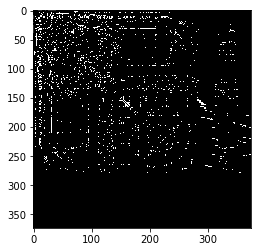

In [411]:
plt.imshow(matrix, cmap='gray')

In [412]:
import bct

In [413]:
bct.number_of_components(matrix+matrix.T)

1

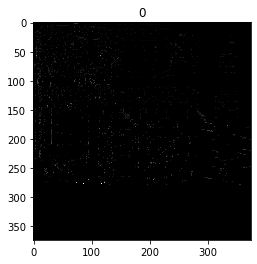

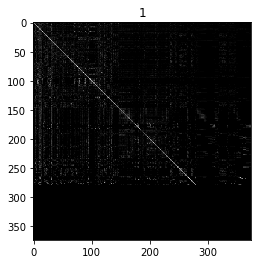

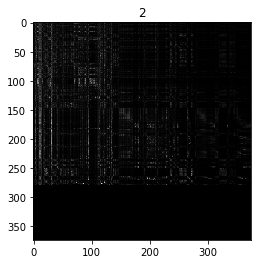

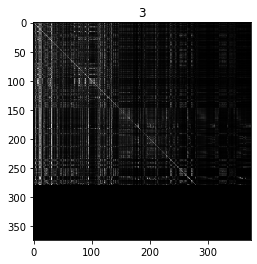

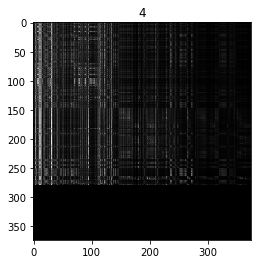

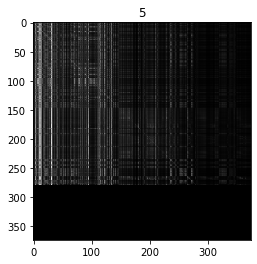

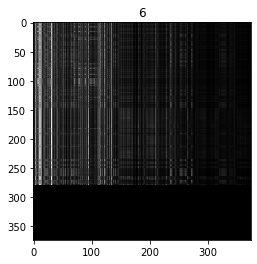

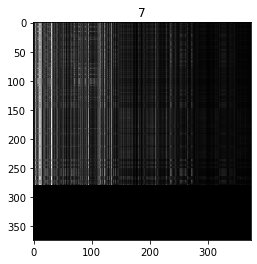

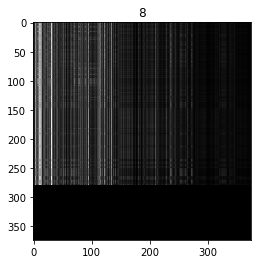

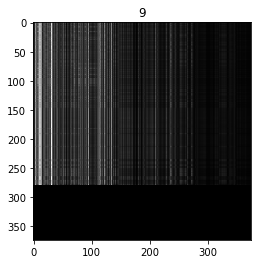

In [414]:
#digression
from itertools import repeat
M = matrix.copy()

#normalize to make a markov transition matrix
def norm_markov(M):
    rowsums = M.sum(1)
    M = M/rowsums
    M = np.nan_to_num(M, copy=False)
    return M

M = norm_markov(M)

for i,m in enumerate(repeat(M, 10)):
    if i%1==0: plt.imshow(M,cmap='gray');plt.title(i); plt.show()
    M=norm_markov(M@m)



In [278]:
GG = nx.from_numpy_array(M>0, create_using=nx.DiGraph)

In [279]:
nx.number_attracting_components(GG)

95

In [237]:
np.any(np.isnan(m))
np.nan_to_num(m, 0)

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [250]:
np.any(np.isnan(m))

False

In [154]:
matrix.sum()

5130.0

In [155]:
G.number_of_edges()

5130

In [156]:
1028 + 2746

3774

(array([68., 38., 11., 19., 35., 29., 38., 23., 15., 16., 12., 14., 20.,
         3.,  4.,  6.,  2.,  6.,  2.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([  3.  ,   6.66,  10.32,  13.98,  17.64,  21.3 ,  24.96,  28.62,
         32.28,  35.94,  39.6 ,  43.26,  46.92,  50.58,  54.24,  57.9 ,
         61.56,  65.22,  68.88,  72.54,  76.2 ,  79.86,  83.52,  87.18,
         90.84,  94.5 ,  98.16, 101.82, 105.48, 109.14, 112.8 , 116.46,
        120.12, 123.78, 127.44, 131.1 , 134.76, 138.42, 142.08, 145.74,
        149.4 , 153.06, 156.72, 160.38, 164.04, 167.7 , 171.36, 175.02,
        178.68, 182.34, 186.  ]),
 <a list of 50 Patch objects>)

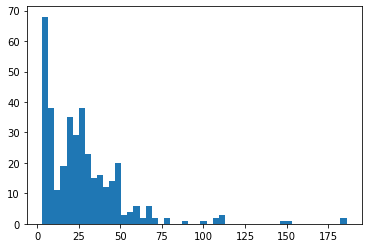

In [90]:
# degree distribution
plt.hist([d for _,d in deg], bins=50)

In [91]:
muscles

,source,target
86,ADEL,MDL05
87,AS01,MDL05
88,AS01,MDR05
89,AS01,MDL08
90,AS01,MDR08
...,...,...
645,DA09,MDR23
646,AS11,MDL24
647,AS11,MDL23
648,AS11,MDR24


In [93]:
muscles.loc[:,'target'].values[:10]

array(['MDL05', 'MDL05', 'MDR05', 'MDL08', 'MDR08', 'MDL08', 'MDR08',
       'MDL07', 'MDR07', 'MDL10'], dtype=object)

In [415]:
#G.remove_nodes_from(muscles.loc[:,'Neuron 2'].values) # should you remove muscles?

In [131]:
L = nx.average_shortest_path_length(G)
C = nx.algorithms.cluster.average_clustering(G)
print(L, C)

NetworkXError: Graph is not weakly connected.

The average number of "jumps" from one node to another is just below 3. This is surprisingly small, considering the network is around 300 neurons!

Let's compare it to a random graph of the same parameters (n,m): random graphs are known to have a very low hop count. (Random graphs are covered in another notebook).

In [132]:
def get_nm(G):
    return G.number_of_nodes(), G.number_of_edges()

376 5130
376 5130


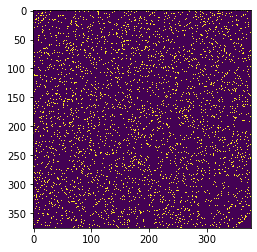

In [133]:
n,m = get_nm(G)

print(n, m)
R = nx.gnm_random_graph(n,m)
#R = nx.barabasi_albert_graph(n,7)

n_rand, m_rand = get_nm(R)
print(n_rand, m_rand)

plt.imshow(to_numpy_matrix(R))

In [134]:
L_random = nx.average_shortest_path_length(R)
C_random = nx.algorithms.cluster.average_clustering(R)
print(L_random, C_random)

2.052354609929078 0.07091573537408384


**Conclusion**: The connectome has an average path length almost as low as a random network (minimal). This is what we had expected, testifying to a near-optimal solution of reducing wiring cost. But why then, might you ask, wouldn't it be better for evolution to have gone for a random topology, to get the path length even a little lower?

The answer lies in the clustering coefficient, which is vastly higher in the C. elegans connectome. What is the meaning of the clustering coefficient? Does it have an evolutionary reason? Sporns (2004) argues that clustering facilitates segregation and thus specialization in subnetworks of the brain. Consider the primary visual cortex: it makes sense for it to have a higher intra-connectivity than inter-connectivity to any other arbitrary region, so it can focus on performing the task of early visual processing. 

This combination of a low L and high C is the characteristic trait of a small-world network. The small-world network can thus be seen as a trade-off between high communication efficiency (L) and high specialization (C).

In [135]:
# Perhaps add a point about robustness to percolation?

In [136]:

#add network metrics, like pagerank, for exploratory fun


# Control theory (in progress)
The research is rooted in control theory: based on the structural connectivity, how can one signal control the output? Can different outputs be controlled independently? By outputs here, we mean muscle cells, the actual effectors of behaviour. Each muscle cell is innervated by motor neuron - the interface from neuron and mucle. Just from the definitions it is obvious that obliterating a motor neuron has a crucial impact on motor function. 

A basic result in control theory is that using k control units, at most k output units can be independently controllable. So for instance, if we wish to control 3 muscle cells through the bottleneck of 2 motor neurons, we can only control 2 of the muscles independently. (use figure for this). 

This becomes important as each muscle needs to be innervated by motor neurons.

To copmute this we need to introduce some values. 

First, M is the number of control targets (muscles). N is the number of neurons (N). The connection diagram of the neurons and muscles is an N+M x N+M matrix, **A**. **B** is a (N+M)xS matrix signifying which nodes receive external control signals (e.g. sensory signals). **C** is a matrix, where each row signifies which units we attempt to control (i.e. the muscles).  

Kalman's criterion is a theoretical prerequisite for a system to be controllable: 
$$ rank [CB, CAB, CA^2B, ..., CA^{N+M+1}B] = M$$

A problem with computing this is that there exist an incomprehensible amount of configurations for the edge weights, and we would need to test all of them. Instead the researchers used *structural controlability*, which is only dependent on the connectome *structure*, without regarding its exact synapse weights or the input signals.

In [94]:
from numpy.linalg import matrix_power, matrix_rank

def is_kalman(A,B,C, random_state=1):
    M = C.shape[0]
    return kalman(controllability_matrix(A,B,C), M, random_state=random_state)

def kalman(kal, M, random_state=1):
    """
    Checks whether kalman condition is satisfied for a system. 
    Non-zero weights are randomly set to avoid a Lebesque measure of zero.
    """
    kal_rnd = np.random.rand(*kal.shape)#*kal
    rnk = matrix_rank(kal*kal_rnd)
    print(f"Rank = {rnk} \t M = {M}")
    return(rnk == M)

def controllability_matrix(A,B,C):
    """
    Returns
    -------
    the matrix [CB, CAB, CA^2B....CA^(M+N-1)B]
    """
    M = C.shape[0]
    N = A.shape[0] - M
    ll = [_controllability_matrix(A,B,C,k) for k in range(M+N)]
    if ll[0].ndim == 1: return np.vstack(ll)#.T
    return np.concatenate(ll, axis=1)

def _controllability_matrix(A,B,C,k):
    """
    Helper function, computes matrix product C@A^k@B
    """
    AA = matrix_power(A,k)
    return C@AA@B
   #if k==0: return C@B
   #return _controllability_matrix(A, B, C@B, k-1)


#### Simple example

we have N=2 neurons and M=2 muscles. We name the cells (neurons and muscles combined) from 1 to 4 (which is assigned as 1, which is 2... is not important). The connectivity diagram is represented as a matrix A, below. B is the matrix of which cells receive external input (i.e. sensory input). C is the one-hot encoded matrix over nodes we wish to control (just 1 for muscle cells and 0 for neurons).

In [95]:
def show_sys(A,B,C, plot=True):   
    for l,e in zip(["A","B","C"],(A,B,C)): print(l,':\n', e, end='\n\n')
    if plot == True:
        H = nx.from_numpy_array(A.T, create_using=nx.DiGraph)
        pos = nx.kamada_kawai_layout(H)
        n = A.shape[0]
        labels={k:v for k,v in zip(range(n), np.arange(n)+1)}
        nx.draw(H, pos=pos, with_labels=True, labels=labels)

The matrix entries are set to 1 just to signify a connection, but the actual weight is not necessarily 1 (in fact that is highly unlikely. 

In [96]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder()
#
#trans = enc.fit_transform(C)
#trans.toarray()
#B = np.array([[0]]) # to receive sensory signal
#B = enc.fit_transform(B).toarray()
#C = np.array([[1,2]]) # to be controlled
#C = enc.fit_transform(C).toarray()

In [97]:
A = np.array([[0,0,0],
              [1,0,0],
              [1,0,0]]) # connectome diagram

B = np.array([[1,0,0]]).T  # the nodes to receive signal
C = np.array([[0,1,0],[0,0,1]]) # the nodes to control


In [98]:
np.nonzero(C)

(array([0, 1], dtype=int64), array([1, 2], dtype=int64))

A :
 [[0 0 0]
 [1 0 0]
 [1 0 0]]

B :
 [[1]
 [0]
 [0]]

C :
 [[0 1 0]
 [0 0 1]]



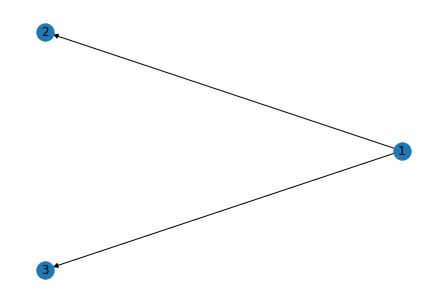

In [99]:
show_sys(A,B,C)

In [100]:
is_kalman(A,B,C)

Rank = 1 	 M = 2


False

In [101]:
C@A@A@B

array([[0],
       [0]])

A :
 [[0 0 0]
 [1 0 0]
 [1 0 0]]

B :
 [[1 0]
 [0 1]
 [0 0]]

C :
 [[0 1 0]
 [0 0 1]]



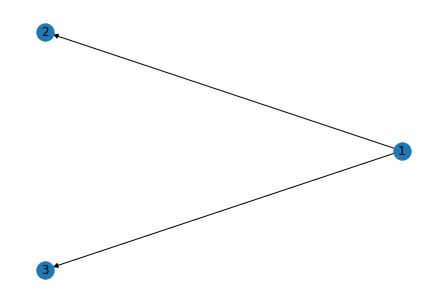

In [102]:
# lets give signal to both first and second
B = np.array([[1,0,0],[0,1,0]]).T
show_sys(A,B,C)

In [103]:
# now it is controllable
is_kalman(A,B,C)

Rank = 2 	 M = 2


True

In [104]:
# a larger example
A = np.array([[0,0,0,0],
              [1,0,0,0],
              [1,0,0,0],
              [0,0,1,0]])

# only neuron #1 receives an input signal
B = np.array([[1,0,0,0]]).T

# we wish to control those indexed 1 and 3
C = np.array([[0,1,0,0],
             [0,0,0,1]])

M = C.shape[0]
N = A.shape[0] - M
print(M, N)

2 2


A :
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]

B :
 [[1]
 [0]
 [0]
 [0]]

C :
 [[0 1 0 0]
 [0 0 0 1]]



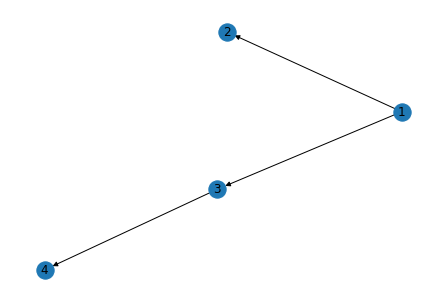

In [105]:
show_sys(A,B,C)

In [106]:
controllability_matrix(A,B,C)

array([[0, 1, 0, 0],
       [0, 0, 1, 0]])

In [107]:
is_kalman(A,B,C)

Rank = 2 	 M = 2


True

In this case we change the desired control units from 2 and 4 to 2 and 3.

A :
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]

B :
 [[1]
 [0]
 [0]
 [0]]

C :
 [[0 1 0 0]
 [0 0 1 0]]

Rank = 1 	 M = 2


False

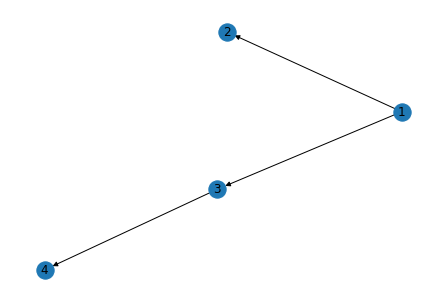

In [108]:
# another case
C = np.array([[0,1,0,0],
              [0,0,1,0]])
show_sys(A,B,C)
is_kalman(A,B,C)

In [109]:
controllability_matrix(A,B,C)

array([[0, 1, 0, 0],
       [0, 1, 0, 0]])

In [110]:
# example from Liu et al (2011) https://www.nature.com/articles/nature10011.pdf
A = np.array([[0,0,0,0],
              [1,0,0,0],
              [1,0,0,1],
              [1,0,0,0]])

B = np.array([[1,0,0,0],
             [0,1,0,0]]).T

C = np.eye(*A.shape)

M = C.shape[0]; N=A.shape[0]-M
print(M, N)

4 0


A :
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 0 0]]

B :
 [[1 0]
 [0 1]
 [0 0]
 [0 0]]

C :
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]



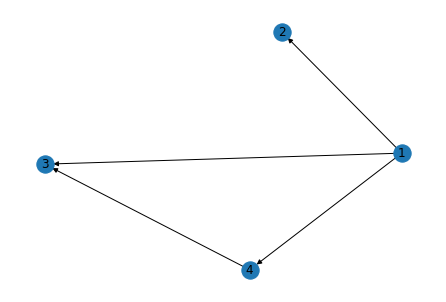

In [111]:
show_sys(A,B,C)

In [112]:
is_kalman(A,B,C)

Rank = 4 	 M = 4


True

We could start to test it on the connectome, but we are not interested in whether the muscles are all independently controllable (in fact some of them are not). So this would return False in that case.

We introduce the linking graph. 

The linking number of the linking graph sets an upper bound to the max number of controllable units (based on the case where C is the identity matrix, i.e. we wish to control all nodes).




Find maximum matching of subgraph

In [113]:
nx.is_bipartite(G)

False

In [114]:
G.is_directed()

True

In [115]:
nx.max_weight_matching(nx.Graph(G))

{('ADAL', 'AVBL'),
 ('ADAR', 'AVBR'),
 ('ADEL', 'MDL05'),
 ('ADER', 'SAAVR'),
 ('ADFL', 'RIR'),
 ('ADFR', 'AIZR'),
 ('AIAR', 'ASKR'),
 ('AIBL', 'SMDDR'),
 ('AIBR', 'VB01'),
 ('AIML', 'ASGL'),
 ('AIYR', 'AIYL'),
 ('AIZL', 'ASIL'),
 ('ALML', 'BDUL'),
 ('ALMR', 'SIADL'),
 ('ALNL', 'SAAVL'),
 ('ALNR', 'SMBDL'),
 ('AQR', 'BAGL'),
 ('AS01', 'MDR05'),
 ('AS02', 'MDL07'),
 ('AS05', 'MDR14'),
 ('AS09', 'MDR17'),
 ('ASEL', 'AWAL'),
 ('ASER', 'AFDL'),
 ('ASGR', 'AINL'),
 ('ASHR', 'RIFR'),
 ('ASJL', 'ASKL'),
 ('ASJR', 'AIMR'),
 ('AUAL', 'IL2DL'),
 ('AVEL', 'IL1R'),
 ('AVER', 'RMDVR'),
 ('AVFL', 'MVL11'),
 ('AVG', 'RIFL'),
 ('AVHR', 'PHCR'),
 ('AVJL', 'PVWL'),
 ('AVJR', 'URXL'),
 ('AVL', 'RIS'),
 ('AWAR', 'AFDR'),
 ('AWBL', 'AWBR'),
 ('AWCL', 'AIAL'),
 ('AWCR', 'ASIR'),
 ('BAGR', 'AINR'),
 ('BDUR', 'URADR'),
 ('CEPVL', 'URAVL'),
 ('CEPVR', 'MVR04'),
 ('DA01', 'MDL08'),
 ('DA03', 'MDL10'),
 ('DA04', 'MDL12'),
 ('DA05', 'MDL14'),
 ('DA07', 'MDL17'),
 ('DA08', 'MDR20'),
 ('DA09', 'MDR24'),
 ('DB02', '

In [116]:
nx.maximal_matching(G)

{('ADAR', 'ADAL'),
 ('ADEL', 'AINL'),
 ('ADFL', 'AIZL'),
 ('ADFR', 'AIAR'),
 ('AIBL', 'AFDL'),
 ('AIBR', 'ADLR'),
 ('ALA', 'RID'),
 ('AS05', 'DB03'),
 ('AS06', 'PLMR'),
 ('AS07', 'MDL13'),
 ('AS08', 'MDL15'),
 ('AS09', 'MDL20'),
 ('AS10', 'MDR20'),
 ('ASEL', 'ASIR'),
 ('ASHL', 'ADLL'),
 ('ASIL', 'ASKL'),
 ('ASKR', 'ASJR'),
 ('AUAL', 'AINR'),
 ('AVAR', 'AQR'),
 ('AVBL', 'AS03'),
 ('AVBR', 'AIML'),
 ('AVDL', 'AS01'),
 ('AVDR', 'ADER'),
 ('AVEL', 'AIZR'),
 ('AVJL', 'AVFL'),
 ('AVJR', 'AVAL'),
 ('AVL', 'AVFR'),
 ('AVM', 'ALMR'),
 ('AWAL', 'AIYL'),
 ('AWBL', 'AWBR'),
 ('AWCR', 'ASGR'),
 ('BDUL', 'AVHL'),
 ('BDUR', 'HSNR'),
 ('DA03', 'AS04'),
 ('DA07', 'MDR15'),
 ('DB01', 'AS02'),
 ('DB05', 'MDL18'),
 ('DB06', 'MDL17'),
 ('DVC', 'DVB'),
 ('FLPL', 'DVA'),
 ('FLPR', 'AVER'),
 ('HSNL', 'ASJL'),
 ('IL1L', 'IL1DL'),
 ('IL2DL', 'RMEL'),
 ('IL2DR', 'RMED'),
 ('IL2L', 'IL2VL'),
 ('IL2R', 'IL1VR'),
 ('LUAL', 'PHBL'),
 ('LUAR', 'PHCR'),
 ('OLLR', 'IL1DR'),
 ('OLQDR', 'SIBVR'),
 ('OLQVL', 'IL1VL'),
 ('

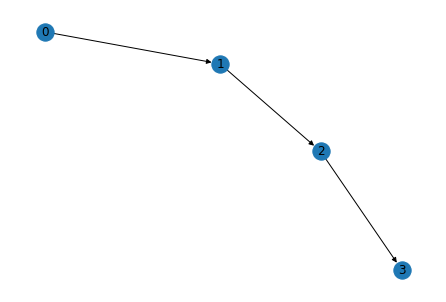

In [117]:
H = nx.path_graph(4, create_using=nx.DiGraph)
nx.draw(H, with_labels=True)

In [118]:
nx.max_weight_matching(H)

{(0, 1), (2, 3)}

In [119]:
star = np.array([[0,0,0,0],
                 [1,0,0,0],
                 [1,0,0,0,],
                 [1,0,0,0]]).T

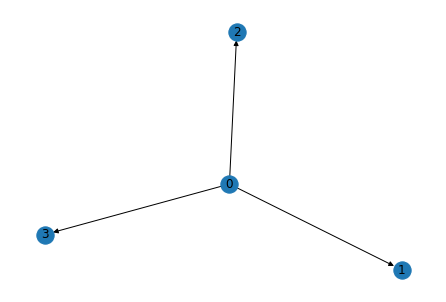

In [120]:
H = nx.from_numpy_array(star, create_using=nx.DiGraph)
nx.draw(H, with_labels=True)

In [121]:
nx.maximal_matching(H)

{(0, 1)}

In [122]:
nx.max_weight_matching(nx.Graph(H))

{(0, 3)}

In [123]:
star = np.array([[0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]]).T

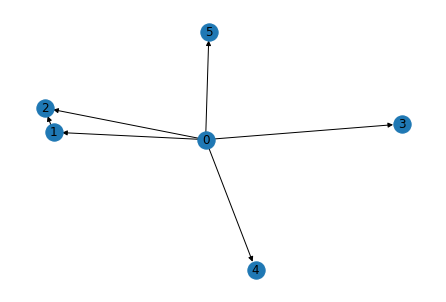

In [124]:
H = nx.from_numpy_array(star, create_using=nx.DiGraph)
nx.draw(H, with_labels=True)

In [125]:
nx.maximal_matching(H.to_undirected())

{(0, 1)}

In [126]:
nx.max_weight_matching(H.to_undirected())

{(0, 5), (1, 2)}

In [419]:
# general:
max_matching = nx.max_weight_matching(H.to_undirected())
N_D = len(max_matching)

H.number_of_nodes() - N_D # number of controllable nodes

4

Problem: the above method is not helpful for directed networks.

In [127]:
G.number_of_nodes()

374

In [128]:
max_matching = nx.max_weight_matching(G.to_undirected())

In [129]:
G.number_of_nodes() - len(max_matching)

190

The above only works for *undirected* graphs. Generalize it. 

In [130]:
# make bipartite representation of digraph 
# https://www.hindawi.com/journals/mpe/2016/4702387/

F = nx.Graph()
Vp = list(G.nodes) # V+
Vm = Vp.copy()     # V-
Vp = list(map(lambda n: n+'+', Vp))
Vm = list(map(lambda n: n+'-', Vm))

In [131]:
F.add_nodes_from(Vp)
F.add_nodes_from(Vm)

In [132]:
for u, v in G.edges:
    F.add_edge(u+'+', v+'-')

In [133]:
F.number_of_edges()

5129

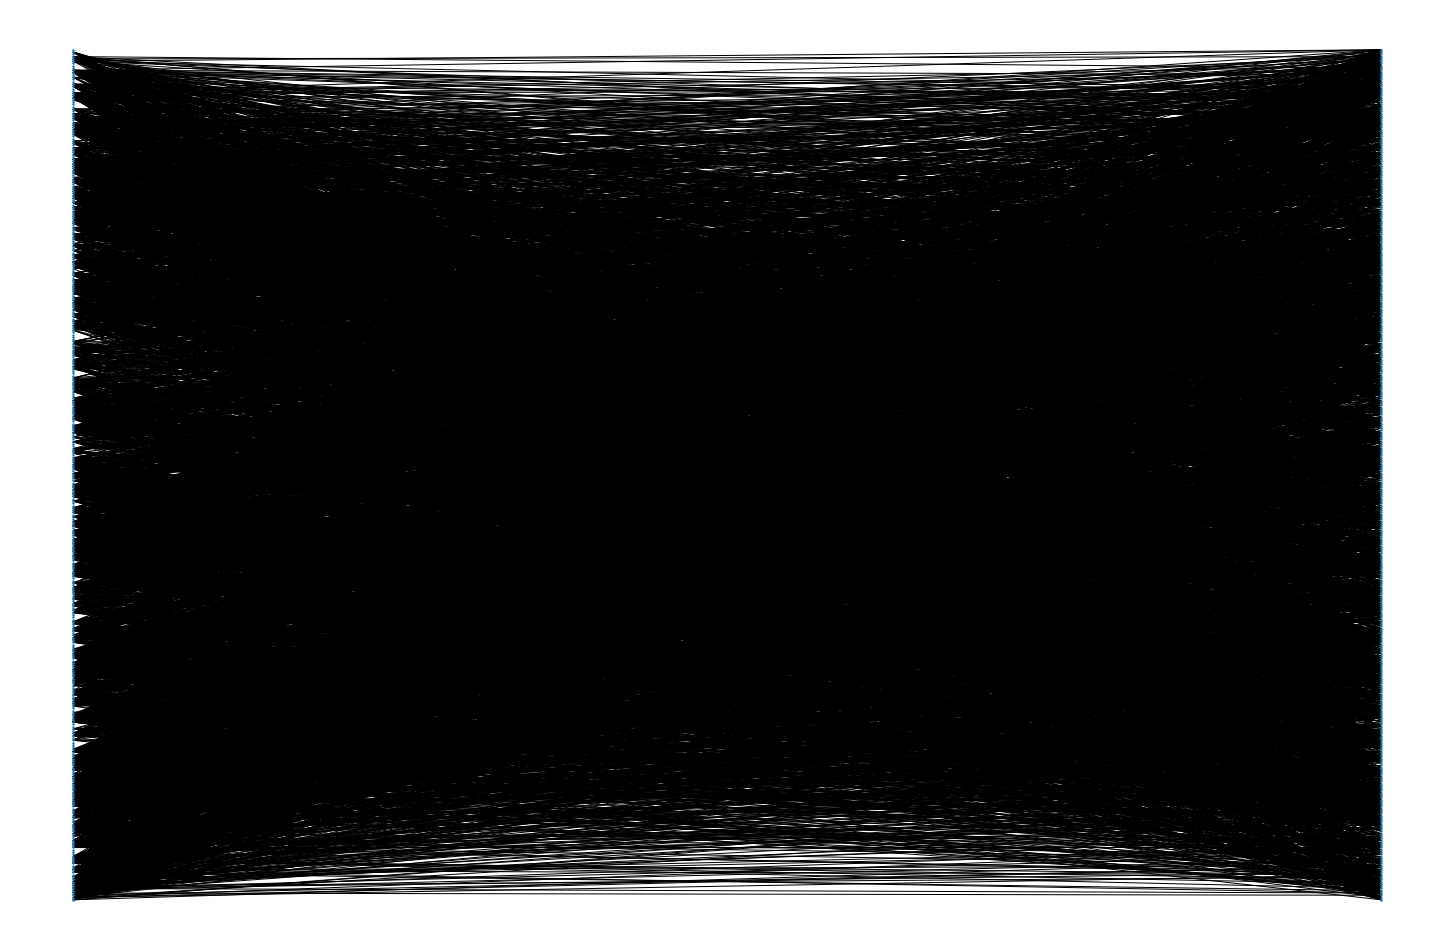

In [427]:
plt.figure(figsize=(20,13))
nx.draw(F, pos=nx.bipartite_layout(F, Vp), node_size=2)

In [134]:
# now F is a bipartite representation of G

In [135]:
to_remove = list(nx.connected_components(F))[1:]
to_remove = [st.pop() for st in to_remove] # get rid of nested sets

In [136]:
len(to_remove)

95

In [137]:
F.remove_nodes_from(to_remove)

In [138]:
max_matching = nx.algorithms.bipartite.matching.hopcroft_karp_matching(F)

In [141]:
MM = len(max_matching)
MM

558

In [140]:
F.number_of_nodes()

653

In [435]:
# minimum number of nodes needed to control G fully
N_D = max(F.number_of_nodes() - len(max_matching), 1)
N_D 

95

In [436]:
# the driver nodes are the unmatched nodes

#Definition 4. For a digraph, matching is a subset of edges with no common starting-nodes
#or no common ending-nodes. That is to say, no two edges in share a common starting-node 
#or a common ending-node. A node is matched if it is an ending-node of a matching edge. 
#Otherwise, it is unmatched.


matched_nodes = {v[:-1] for _,v in max_matching.items()}

In [437]:
matched_nodes.difference??

In [438]:
unmatched_nodes = set(G.nodes()).difference(matched_nodes)

In [439]:
unmatched_nodes[:10]

TypeError: 'set' object is not subscriptable

# How to determine the number of controllable nodes: linking graphs

<img src="assets/linking_graph.png" width=750 />


The mathematics of network flow: 
https://sites.cs.ucsb.edu/~suri/cs231/Flows.pdf


In [142]:
### credit to Towlson et al for the code below
### Available (and slightly modified) from:
### https://github.com/EmmaTowlson/c-elegans-control for the code to follow

In [374]:
# linking size (derived from linking graph) sets upper bound to number of controllable nodes

def linking_graph(G, sensors, sinks, depth):
    """
    Construct a linking graph from nx.DiGraph G
    """
    H = nx.DiGraph() 
    for edge in G.edges():
        u,v = edge
        c = u + 'a1'
        d = v + 'a1'
        
        if not H.has_node(c):
                for i in range(1,depth+1):
                        H.add_edge(u+'a'+str(i),u+'b'+str(i),capacity=1)
        if not H.has_node(d):
                for i in range(1,depth+1):
                        H.add_edge(v+'a'+str(i),v+'b'+str(i),capacity=1)
        if not H.has_edge(u+'b'+str(2),v+'a'+str(1)):
            for i in range(2,depth+1):
                    H.add_edge(u+'b'+str(i),v+'a'+str(i-1),capacity=1)
    
    ## add 'Source' nodes into the linking graph
    for s in sensors:
        for i in range(1,depth+1):
            H.add_edge('SOURCE', s+'a'+str(i), capacity=100)
            
    for s in sinks:
        H.add_edge(s+'b1', 'SINK', capacity=100)
    
    return H


In [360]:
# not working, ignore
def lg(G, sensors, depth=120):
    H = nx.DiGraph()
    for u,v in G.edges():   
        for t in range(depth):
            H.add_edge(u+str(t), v+str(t+1), capacity=1)
    for s in sensors:
        for t in range(depth):
            H.add_edge('SOURCE', s+str(t), capacity=100)
            
    return H

Simple example first (from above figure)

In [148]:
D = nx.DiGraph()
edge_list=[('x1','x2'),('x1','x3'), ('x3','x4')]
D.add_edges_from(edge_list)

In [149]:
F1 = lg(D, sensors=['x1'], depth=4)
F2 = linking_graph(D, sensors=['x1'], depth=4)

In [150]:
F1.add_edge('x24','SINK',capacity=100)
F1.add_edge('x44','SINK',capacity=100)

F2.add_edge('x2'+'b1','SINK',capacity=100)
F2.add_edge('x4'+'b1','SINK',capacity=100)

In [151]:
F2.nodes()

NodeView(('x1a1', 'x1b1', 'x1a2', 'x1b2', 'x1a3', 'x1b3', 'x1a4', 'x1b4', 'x2a1', 'x2b1', 'x2a2', 'x2b2', 'x2a3', 'x2b3', 'x2a4', 'x2b4', 'x3a1', 'x3b1', 'x3a2', 'x3b2', 'x3a3', 'x3b3', 'x3a4', 'x3b4', 'x4a1', 'x4b1', 'x4a2', 'x4b2', 'x4a3', 'x4b3', 'x4a4', 'x4b4', 'SOURCE', 'SINK'))

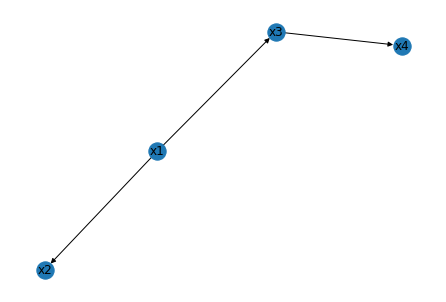

In [152]:
nx.draw(D, with_labels=True)

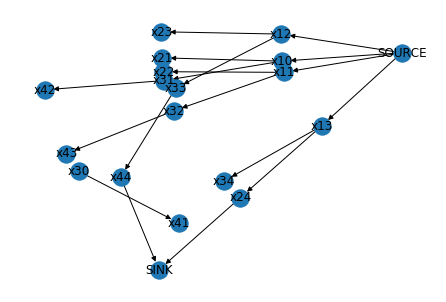

In [153]:
nx.draw(F1,pos=nx.layout.kamada_kawai_layout(F1), with_labels=True)

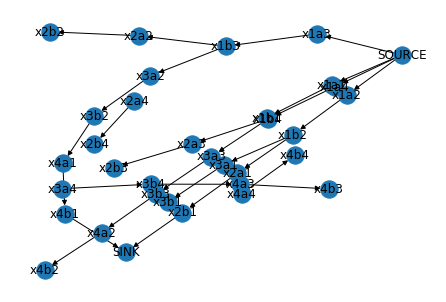

In [154]:
nx.draw(F2,pos=nx.layout.kamada_kawai_layout(F2), with_labels=True)

In [155]:
flow_value, flow_dict = nx.maximum_flow(F1, 'SOURCE', 'SINK')
flow_value

2

In [156]:
flow_value, flow_dict = nx.maximum_flow(F2, 'SOURCE', 'SINK')
flow_value

2

## Finding the upper bound
There exist no known way to reliably determine the number of nodes controllable in a given network architecture. However, there is one method to determine the upper bound, and one for the lower bound. The above method found the upper bound, and we will do this now to the connectome.

In [364]:
print(G.number_of_nodes()) #374
print(G.number_of_edges()) #5129

374
5129


In [375]:
sensors = ['AVM','ALML','ALMR'] # anterior gentle touch
H = linking_graph(G, sensors, muscle_cells, 120) # depth 120 was found empirically

In [362]:
#H2.add_edges_from(muscle_links)

In [166]:
import time

In [365]:
# add sink nodes
#for cell in muscle_cells:
#    H.add_edge(cell+'b1', 'SINK', capacity=100)
    
#for cell in muscle_cells:
#    H2.add_edge(cell+str(119), 'SINK', capacity=100)

In [366]:
#print(H1.number_of_nodes())
#print(H2.number_of_nodes())
#
#print(H1.number_of_edges())
#print(H2.number_of_edges())

In [376]:
# The upper bound of muscle controllability for the healthy worm
start = time.time()
flow_value, flow_dict = nx.maximum_flow(H, 'SOURCE', 'SINK')
end = time.time()
print('When no ablation, the Upper Bound is:')
print(flow_value)
print('time == ' + str(end-start))
print('\n')

When no ablation, the Upper Bound is:
89
time == 65.16435217857361




No more than 89 of the 95 neurons can be controlled completely independently. Now this is the upper bound, so it can in principle be much lower. We also need to find this lower bound.

# Find lower bound

When the nodes in the target set do not receive the external control signals u(t) directly,
the network can be separated into two subnetworks, GO and GM (see the schematic picture
Extended Data Figure 2(e)), where GO contains a subnetwork GS, each node in which
receives the external signals directly, and a subnetwork GD, each node in which directly
connects to the nodes in the target set. The set of nodes in GM, GS and GD are denoted
8
by VM, VS and VD respectively. Firstly, taking into account the high density of real neural
networks, search for a subnetwork in (GO 􀀀 GD) that can be fully structurally controlled
by the nodes VS; Secondly, add GD's nodes (and their associated links) one-by-one into the
subnetwork found in the rst step, until the new subnetwork cannot be fully controlled
by VS. Denote the VD's subset that are in the nal subnetwork GF found in this step as
VD-; Thirdly, search for a maximum matching [S30] from VD- to VM, obtaining a node set
U  VM that are covered by this matching. Note that there may be many congurations
of U but its cardinality z is unique. This is the lower bound.

In [171]:
import random
import time
import re
from random import shuffle
from networkx.algorithms.flow import shortest_augmenting_path
from networkx.algorithms.flow import preflow_push
from networkx.algorithms.flow import edmonds_karp

In [263]:
# first subgraph

sensors = ['ALML','ALMR','AVM']
depth = 50

G_nomuscle = G.copy()
G_nomuscle.remove_nodes_from(muscle_cells)

# test 1 - those laballed 'Motor' in G
motor_neurons = [k for k,v in nx.get_node_attributes(G,'Type').items() if v=='Motor']
len(motor_neurons) #126

# test 2 - those connected to muscles
#motor_neurons = np.unique([u for u,v in G.edges() if v.startswith('M')])
#motor_neurons.shape #118

H = linking_graph(G_nomuscle, sensors, motor_neurons, depth)

In [264]:
print(G.number_of_nodes())
G.number_of_edges()

374


5129

In [271]:
flow_value, flow_dict = nx.maximum_flow(H,'SOURCE','SINK')

print(flow_value)

# ensure that flow_value == number of motor neurons

118


In [272]:
print(flow_value)
print(len(motor_neurons))

118
118


So far so good

### Second subgraph (motor neurons to muscles)

In [273]:
#motor_to_muscle = muscles[bdwl][['Neuron','Landmark']]
#motor_to_muscle.columns = ['source', 'target']
muscles # should be 552 edges

,source,target
86,ADEL,MDL05
87,AS01,MDL05
88,AS01,MDR05
89,AS01,MDL08
90,AS01,MDR08
...,...,...
645,DA09,MDR23
646,AS11,MDL24
647,AS11,MDL23
648,AS11,MDR24


In [274]:
muscles.source.unique().shape

(118,)

In [242]:
G_onlymuscle.has_edge('ADEL','MDL07')

False

In [275]:
G_onlymuscle = nx.from_pandas_edgelist(muscles)

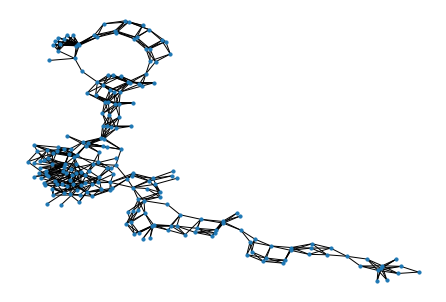

In [221]:
nx.draw(G_onlymuscle, pos=nx.kamada_kawai_layout(G_onlymuscle), node_size=10)

In [237]:
list(motor_neurons).__len__()

126

In [276]:
sensors=motor_neurons
depth=5
H = linking_graph(G_onlymuscle, sensors, muscle_cells, depth)

In [277]:
H.number_of_nodes()

2131

In [279]:
H.number_of_edges()

3863

In [280]:
# add sink nodes
#for cell in muscle_cells:
#    H.add_edge(cell+'b1', 'SINK', capacity=100)

In [281]:
flow_value, flow_dict = nx.maximum_flow(H,'SOURCE','SINK')

In [282]:
flow_value

49

## Experiment: can you make the upper bound decrease from removing nodes? Try removing the nodes with the highest degree.

#### Exercise. Write a function `ablate_test` that takes G and a node, makes a copy of G, removes that node, and finds the upper bound of controllable nodes. It should finally print the neuron name and the number.

In [383]:
# %load solutions/ex....

def ablate_test(G, neuron):
    G_abl = G.copy()
    G_abl.remove_node(neuron)
    H = linking_graph(G_abl, sensors, sinks, depth)
    flow_value,_ = nx.maximum_flow(H,'SOURCE','SINK')
    print(node, flow_value)

In [384]:
######################
# We set the following global variables for the experiments

sensors = ['AVM','ALML','ALMR']
sinks = muscle_cells
depth=120

In [ ]:
ablate_test(G, 'PDB')

As you can see, the number of individually controllable nodes was reduced to 88 just by removing this single node. This will happen in the clear minority of single-neuron ablations. Let's confirm more of the findings from Yan et al 2017:

In [377]:
neurons_to_ablate = ['DD04', 'DD05', 'DD06']

for node in neurons_to_ablate:
    ablate_test(G, node)

DD04 88
DD05 88
DD06 88


In [373]:
# some other non-implicated nodes from the DD class
neurons_to_ablate = ['DD01', 'DD02', 'DD03']

for node in neurons_to_ablate:
    ablate_test(G, node)

DD01 89
DD02 89
DD03 89


In [386]:
# the highest degree nodes
neurons_to_ablate = ['AVAR', 'AVAL']

for node in neurons_to_ablate:
    ablate_test(G, node)

AVAR 88
AVAL 88


As we expected, the highest degree nodes are also crucial for maintaining optimal network control.

# SUPER SLOW

# SUPER SLOW

In [ ]:

# The upper bound of muscle controllability when ablating each neuron group
fp = open('neuron_group_adult.txt','r')
fo = open('result_anterior_SingleGroup_Ablation_adult_UpperBound_loop.txt','w')
tmp = 1;

#for line in fp:
    s = line.split(' ')
    print('If ablating neuron group ' + s[len(s)-2] + ' :')
    ## To print the result, here we use the single neuron s[0] to denote the
    ## neuron group s, for ease.    

    R = H.copy()
    for i in range(1,depth+1):
        for j in range(0,len(s)-1):
            a = s[j] + 'a' + str(i)
            b = s[j] + 'b' + str(i)
            if a in R.nodes():
                R.remove_node(a)
                #print(s[j] + 'a' + str(i))
                R.remove_node(b)
                #print(s[j] + 'b' + str(i))
    time1 = time.clock()
    flow_value, flow_dict = nx.maximum_flow(R, 'SOURCE', 'SINK')
    time2 = time.clock()
    #print(tmp)
    print('time == ' + str(time2-time1))
    print(s)
    print(flow_value)
    print('\n')
    ss = s[0]+'\t'+str(flow_value) + '\n'
    fo.write(ss)
    ## Note: To write the result, here we use the single neuron s[0] to denote the
    ## neuron group s, for ease.
    tmp = tmp + 1
    del(R)
    
fp.close()
fo.close()

###############################################################################
## Note: here we show the methodology for assessing the muscle controllability
## after ablating each neuron group, it can be easily revised for the ablation
## of each individuals (rather than neuron groups).
###############################################################################


#### exercise. Verify the same neurons as the paper which are crucial for control, through ablation. (you could brute force a loop but this is very slow. Just verify the paper's conclusion)

In [ ]:
# ignore
# https://github.com/asutera/kaggle-connectomics